# Model Development for Telco Customer Churn

This notebook implements the model development pipeline for predicting customer churn in the Telco Customer Churn dataset, based on insights from the `EDA.ipynb` exploratory data analysis. The goal is to preprocess the data, engineer features, train and evaluate multiple models, and interpret results to support the Streamlit frontend.

## Objectives
- Preprocess data: Handle categorical encoding, numerical normalization, and class imbalance.
- Engineer features: Create binned `tenure`, `MonthlyCharges/tenure` ratio, service count, and interaction terms.
- Train models: LightGBM, Random Forest, and a stacking ensemble.
- Evaluate models: Focus on recall, F1-score, and ROC-AUC to prioritize churn identification.
- Interpret results: Use SHAP plots to validate feature importance.
- Save model and preprocessing steps for Streamlit integration.

## Dataset
- **Source**: `Data/telco_customer_churn.csv`
- **Features**: 21, with focus on `tenure`, `MonthlyCharges`, `Contract`, `PaymentMethod`, `InternetService`.
- **Target**: `Churn` (Yes/No, ~26.5% Yes).

## Tools
- Pandas, NumPy: Data manipulation
- Scikit-learn: Preprocessing, model evaluation, and stacking
- LightGBM: Gradient boosting model
- SMOTE: Class imbalance handling
- SHAP: Model interpretation
- Joblib: Model and preprocessor persistence
- Matplotlib, Seaborn: Visualizations

## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

c:\Users\Akoba\Desktop\START up\Customer-Churn-Prediction-\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Load and Clean Dataset

In [3]:
# Load dataset
df = pd.read_csv('Data/telco_customer_churn.csv')

# Clean TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.loc[(df['TotalCharges'].isnull()) & (df['tenure'] == 0), 'TotalCharges'] = 0
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Standardize categorical values
for col in ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})

# Drop customerID
df = df.drop('customerID', axis=1)

# Verify
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
display(df.head())

Dataset Shape: (7043, 20)

Missing Values:
 gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Feature Engineering

In [4]:
# Bin tenure
df['tenure_bin'] = pd.cut(df['tenure'], bins=[-1, 12, 24, 72], labels=['0-12', '12-24', '>24'])

# MonthlyCharges/tenure ratio (avoid division by zero)
df['MonthlyCharges_per_tenure'] = df['MonthlyCharges'] / (df['tenure'] + 1)

# Count subscribed services
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df['ServiceCount'] = df[service_cols].apply(lambda x: (x == 'Yes').sum(), axis=1)

# Interaction term: Fiber optic and no OnlineSecurity
df['Fiber_no_Security'] = ((df['InternetService'] == 'Fiber optic') & (df['OnlineSecurity'] == 'No')).astype(int)

# Verify new features
print("\nNew Features:\n", df[['tenure_bin', 'MonthlyCharges_per_tenure', 'ServiceCount', 'Fiber_no_Security']].head())


New Features:
   tenure_bin  MonthlyCharges_per_tenure  ServiceCount  Fiber_no_Security
0       0-12                  14.925000             1                  0
1        >24                   1.627143             2                  0
2       0-12                  17.950000             2                  0
3        >24                   0.919565             3                  0
4       0-12                  23.566667             0                  1


## 4. Preprocessing

In [6]:
# Define features and target
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})

# Define numerical and categorical columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'MonthlyCharges_per_tenure', 'ServiceCount']
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
                    'tenure_bin', 'Fiber_no_Security']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Verify split
print("\nTrain Shape:", X_train.shape)
print("Test Shape:", X_test.shape)
print("Churn Distribution in Train:\n", y_train.value_counts(normalize=True))


Train Shape: (5634, 23)
Test Shape: (1409, 23)
Churn Distribution in Train:
 Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64


## 5. Model Training


Results for Random Forest:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1035
           1       0.59      0.57      0.58       374

    accuracy                           0.78      1409
   macro avg       0.72      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

ROC-AUC: 0.824


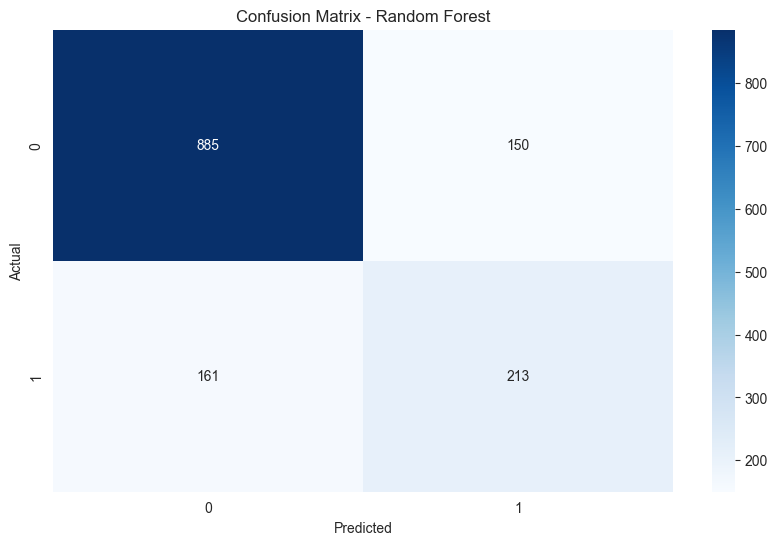

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4358
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Results for LightGBM:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      1035
           1       0.59      0.61      0.60       374

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409

ROC-AUC: 0.837


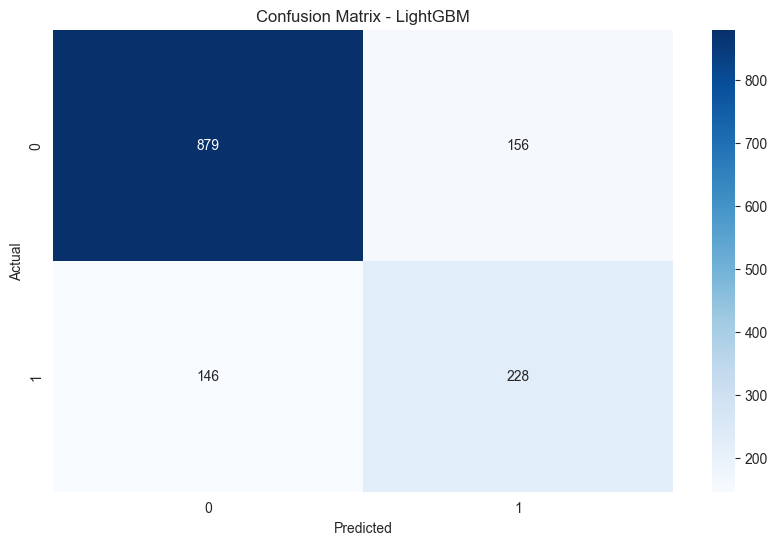

[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4358
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 3311, number of negative: 3311
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4358
[LightGBM] [Info] Number of data points in the train set: 6622, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


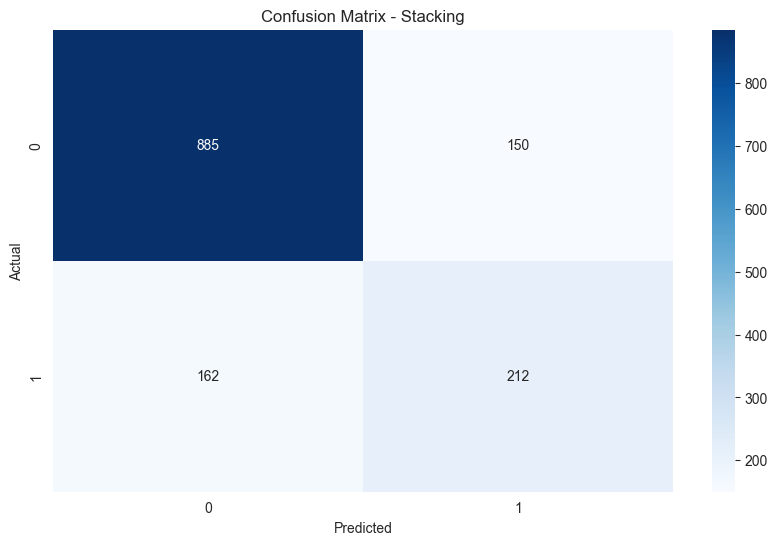

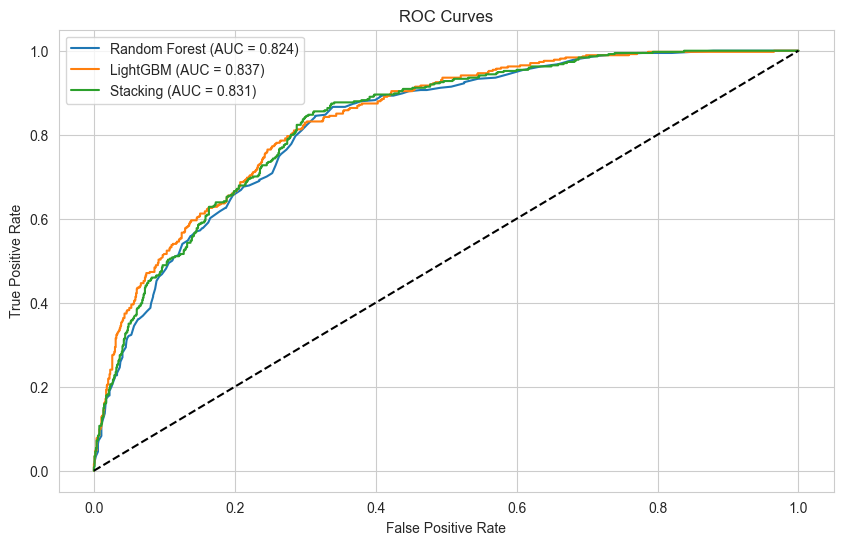

In [7]:
# Define models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lgbm = lgb.LGBMClassifier(random_state=42, n_estimators=100)

# Stacking ensemble
estimators = [('rf', rf), ('lgbm', lgbm)]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)

# Model pipelines with SMOTE
models = {
    'Random Forest': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', rf)
    ]),
    'LightGBM': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', lgbm)
    ]),
    'Stacking': ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('model', stacking)
    ])
}

# Train and evaluate models
results = {}
for name, pipeline in models.items():
    # Fit model
    pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Metrics
    results[name] = {
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    # Print results
    print(f"\nResults for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {results[name]['roc_auc']:.3f}")
    
    # Plot confusion matrix
    plt.figure()
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC Curves
plt.figure()
for name, pipeline in models.items():
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["roc_auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

## 6. Model Interpretation (SHAP)

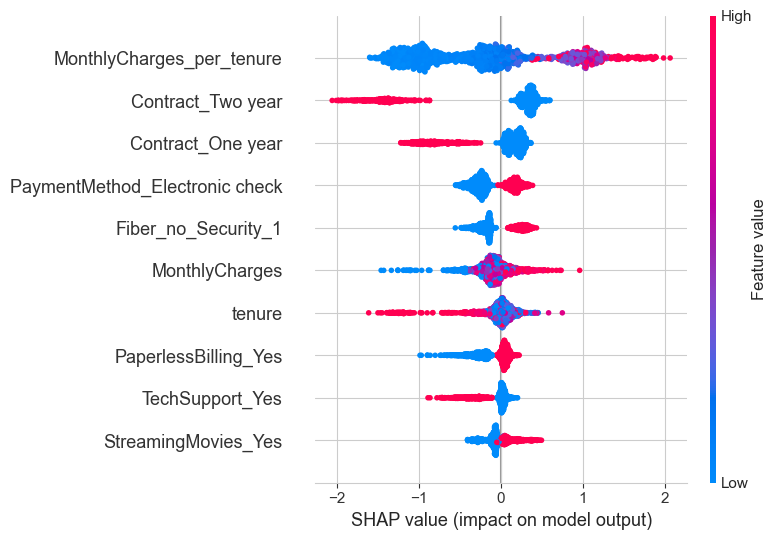

<Figure size 1000x600 with 0 Axes>

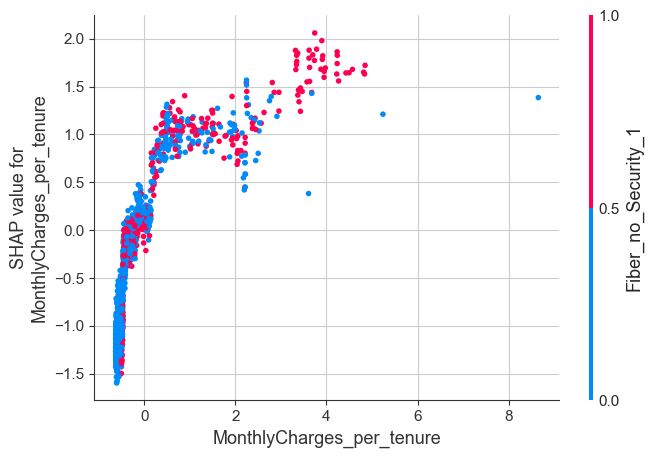

'\n# SHAP summary plot for the positive class (class 1)\nprint("SHAP Values Shape:", np.array(shap_values).shape)\nplt.figure()\nshap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names, max_display=10)\n\nplt.show() \n# SHAP dependence plot for top feature\ntop_feature = feature_names[np.argmax(np.abs(shap_values[1]).mean(0))]\nplt.figure()\nshap.dependence_plot(top_feature, shap_values[1], X_test_transformed, feature_names=feature_names)\nplt.show()\n'

In [14]:
# Select best model (based on F1-score for class 1)
best_model_name = max(results, key=lambda x: results[x]['classification_report']['1']['f1-score'])
best_pipeline = models[best_model_name]

# Get feature names after preprocessing
cat_features = best_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_features)
# Transform X_test for SHAP
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# SHAP explainer
explainer = shap.TreeExplainer(best_pipeline.named_steps['model'] if best_model_name != 'Stacking' else best_pipeline.named_steps['model'].estimators_[1])
shap_values = explainer.shap_values(X_test_transformed)

# Check and reshape SHAP values if needed
if len(np.array(shap_values).shape) == 1:  # If 1D array
    shap_values = np.array(shap_values).reshape(-1, 1)

# SHAP summary plot
plt.figure()
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, max_display=10)

# SHAP dependence plot for top feature
top_feature = feature_names[np.argmax(np.abs(shap_values).mean(0))]
plt.figure()
shap.dependence_plot(top_feature, shap_values, X_test_transformed, feature_names=feature_names)
plt.show()

# SHAP explainer
explainer = shap.TreeExplainer(best_pipeline.named_steps['model'] if best_model_name != 'Stacking' else best_pipeline.named_steps['model'].estimators_[1])
shap_values = explainer.shap_values(X_test_transformed)

"""
# SHAP summary plot for the positive class (class 1)
print("SHAP Values Shape:", np.array(shap_values).shape)
plt.figure()
shap.summary_plot(shap_values[1], X_test_transformed, feature_names=feature_names, max_display=10)

plt.show() 
# SHAP dependence plot for top feature
top_feature = feature_names[np.argmax(np.abs(shap_values[1]).mean(0))]
plt.figure()
shap.dependence_plot(top_feature, shap_values[1], X_test_transformed, feature_names=feature_names)
plt.show()
"""

## 7. Save Model and Preprocessing Pipeline

In [17]:
# Save the best model
joblib.dump(best_pipeline, 'models/telco_churn_model.pkl')

# Save preprocessor
joblib.dump(preprocessor, 'models/preprocessor.pkl')

# Save feature names for Streamlit
with open('models/feature_names.txt', 'w') as f:
    f.write('\n'.join(feature_names))

# Verify saving
print("Model, Preprocessor, and Feature Names Saved!")

Model, Preprocessor, and Feature Names Saved!
